# Edge Case Analysis

We analyze the performance of the trained music genre classification model on edge cases.

In [ ]:
import sys
import os
from pathlib import Path
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm

repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

GENRE_NAMES = ['blues', 'classical', 'country', 'disco', 'hiphop', 
               'jazz', 'metal', 'pop', 'reggae', 'rock']
SAMPLE_RATE = 22050
TRAIN_CHUNK_DURATION = 3.0 # model was trained on 3s chunks

Using device: cuda


In [ ]:
try:
    from model_cnn import ComplexCNN
except ModuleNotFoundError:
    print("Model module not found; loading from notebook via %run ...")
    %run "./04_model_cnn.ipynb"

from utils.datasets_gtzan import GTZANDataset, create_dataloaders

def load_trained_model(model_path, n_classes=10, device='cpu'):
    model = ComplexCNN(n_classes=n_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

Model module not found; loading from notebook via %run ...
SimpleCNN:
SimpleCNN(
  (mel_spec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (amplitude_to_db): AmplitudeToDB()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, ke

C:\Users\mar20\AppData\Local\Temp\ipykernel_12476\660122760.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [ ]:
# Model loading
# Update path to specific run
run_dir = Path("../runs/20251202_114502/") 
model_path = run_dir / 'gtzan_cnn.pth'

# Fallback
if not model_path.exists():
    runs_root = Path("../runs")
    all_runs = sorted([d for d in runs_root.iterdir() if d.is_dir()])
    if all_runs:
        run_dir = all_runs[-1]
        model_path = run_dir / 'gtzan_cnn.pth'
        print(f"Specified model not found. Using latest run: {run_dir}")

print(f"Loading model from: {model_path}")
model = load_trained_model(str(model_path), device=device)

Loading model from: ..\runs\20251202_114502\gtzan_cnn.pth


C:\Users\mar20\AppData\Local\Temp\ipykernel_12476\2053926415.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

In [5]:
# Load Test Data
gtzan_root = repo_root / "data" / "gtzan"
if not gtzan_root.exists():
    print(f"Error: Dataset not found at {gtzan_root}")
else:
    # We use the same split as training to ensure we test on unseen data
    full_dataset = GTZANDataset(str(gtzan_root), cache_to_memory=False)
    
    # Create test loader with standard 3s chunks first to establish baseline
    _, _, test_loader = create_dataloaders(
        full_dataset, 
        batch_size=32, 
        chunk_length_sec=TRAIN_CHUNK_DURATION,
        test_split=0.1
    )
    print(f"Test set size: {len(test_loader.dataset)} chunks")

Created stratified split: 719 train, 180 val, 100 test songs
Applying chunking: 3.0s chunks with 50% overlap
Chunked dataset sizes: 13661 train, 3420 val, 1900 test chunks
Test set size: 1900 chunks


## Analysis of Short Input Sequences

We trained the model on 3-second chunks. However, in real-world scenarios, we might have shorter clips.
We simulate shorter inputs by taking the test set audio and cropping it to shorter durations.
Since the model architecture (CNN) likely expects a fixed input size (corresponding to 3s), we pad the shorter clips with silence to reach the 3s length.
We hypothesize that performance will drop as the signal becomes shorter.

Evaluating on 100 test songs with varying durations...
Testing duration: 0.1s
  Accuracy: 10.00%
Testing duration: 0.5s
  Accuracy: 10.00%
Testing duration: 0.5s
  Accuracy: 10.00%
Testing duration: 1.0s
  Accuracy: 10.00%
Testing duration: 1.0s
  Accuracy: 14.00%
Testing duration: 1.5s
  Accuracy: 14.00%
Testing duration: 1.5s
  Accuracy: 16.00%
Testing duration: 2.0s
  Accuracy: 16.00%
Testing duration: 2.0s
  Accuracy: 17.00%
Testing duration: 2.5s
  Accuracy: 17.00%
Testing duration: 2.5s
  Accuracy: 50.00%
Testing duration: 3.0s
  Accuracy: 50.00%
Testing duration: 3.0s
  Accuracy: 71.00%
  Accuracy: 71.00%


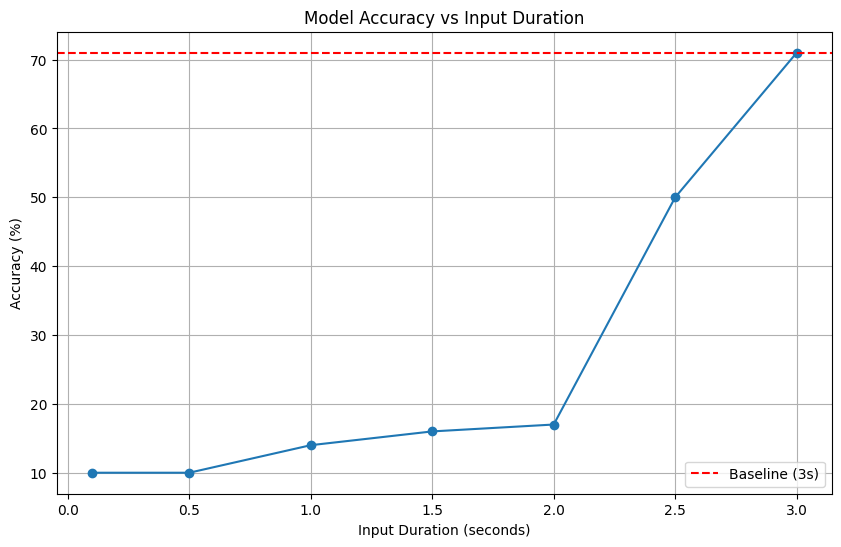

In [ ]:
def evaluate_on_short_sequences(model, dataset, durations, device):
    results = {}
    
    # The test_loader.dataset is a ChunkedDataset wrapping a Subset
    if hasattr(dataset, 'dataset'):
        subset = dataset.dataset
    else:
        subset = dataset

    print(f"Evaluating on {len(subset)} test songs with varying durations...")
    
    for duration in durations:
        print(f"Testing duration: {duration}s")
        correct = 0
        total = 0
        
        for i in range(len(subset)):
            waveform, label = subset[i] # returns full 30s waveform
            
            # Take middle chunk to avoid silence at start
            mid_point = waveform.shape[1] // 2
            target_samples = int(duration * SAMPLE_RATE)
            start = mid_point - target_samples // 2
            end = start + target_samples
            
            chunk = waveform[:, start:end]
            
            # Pad to 3s
            model_input_samples = int(TRAIN_CHUNK_DURATION * SAMPLE_RATE)
            if chunk.shape[1] < model_input_samples:
                padding = model_input_samples - chunk.shape[1]
                chunk_padded = torch.nn.functional.pad(chunk, (0, padding)) # at end
            else:
                chunk_padded = chunk[:, :model_input_samples]
                
            input_tensor = chunk_padded.unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = model(input_tensor)
                pred = torch.argmax(output, dim=1).item()
            
            if pred == label:
                correct += 1
            total += 1
            
        acc = correct / total
        results[duration] = acc
        print(f"  Accuracy: {acc*100:.2f}%")
        
    return results

durations_to_test = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
short_seq_results = evaluate_on_short_sequences(model, test_loader.dataset, durations_to_test, device)

plt.figure(figsize=(10, 6))
plt.plot(list(short_seq_results.keys()), [v*100 for v in short_seq_results.values()], marker='o')
plt.title("Model Accuracy vs Input Duration")
plt.xlabel("Input Duration (seconds)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.axhline(y=short_seq_results[3.0]*100, color='r', linestyle='--', label='Baseline (3s)')
plt.legend()
plt.show()

## Analysis of Difficult Genres

We analyze the confusion matrix to identify which genres are most frequently misclassified.

              precision    recall  f1-score   support

       blues       0.94      0.85      0.90       190
   classical       0.89      0.84      0.86       190
     country       0.71      0.90      0.79       190
       disco       0.83      0.56      0.67       190
      hiphop       0.63      0.99      0.77       190
        jazz       0.85      0.98      0.91       190
       metal       0.96      0.78      0.86       190
         pop       0.68      0.71      0.69       190
      reggae       0.72      0.68      0.70       190
        rock       0.61      0.41      0.49       190

    accuracy                           0.77      1900
   macro avg       0.78      0.77      0.77      1900
weighted avg       0.78      0.77      0.77      1900



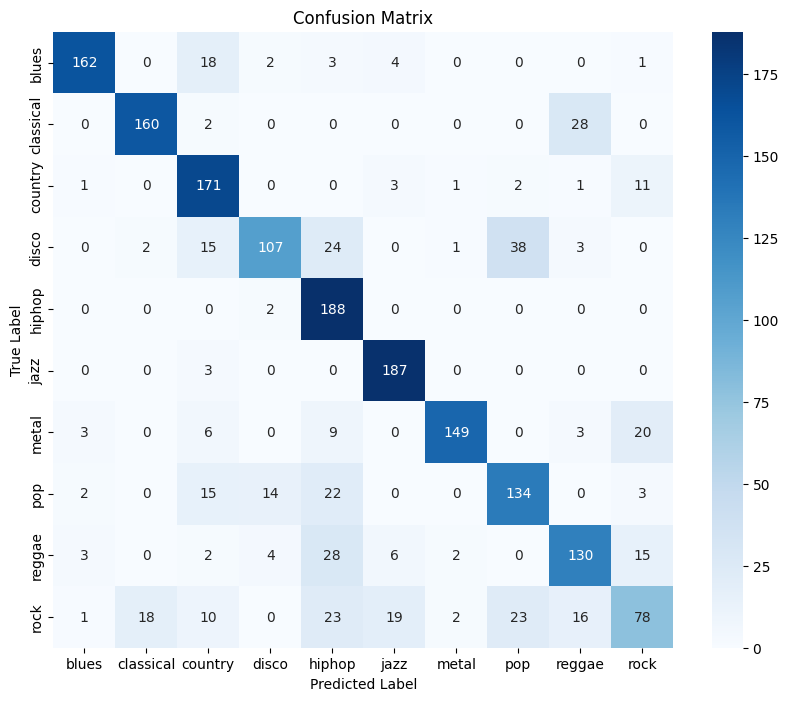


Top 3 Most Difficult Genres:
rock: 41.05% accuracy
disco: 56.32% accuracy
reggae: 68.42% accuracy


In [ ]:
def get_predictions(model, loader, device):
    all_preds = []
    all_labels = []
    all_probs = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
            
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

preds, labels, probs = get_predictions(model, test_loader, device)

print(classification_report(labels, preds, target_names=GENRE_NAMES))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=GENRE_NAMES, yticklabels=GENRE_NAMES)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# lowest performing genres
class_acc = cm.diagonal() / cm.sum(axis=1)
worst_genres_idx = np.argsort(class_acc)[:3]
print("\nTop 3 Most Difficult Genres:")
for idx in worst_genres_idx:
    print(f"{GENRE_NAMES[idx]}: {class_acc[idx]*100:.2f}% accuracy")

## Confidence Analysis

Do misclassified examples have lower confidence scores?

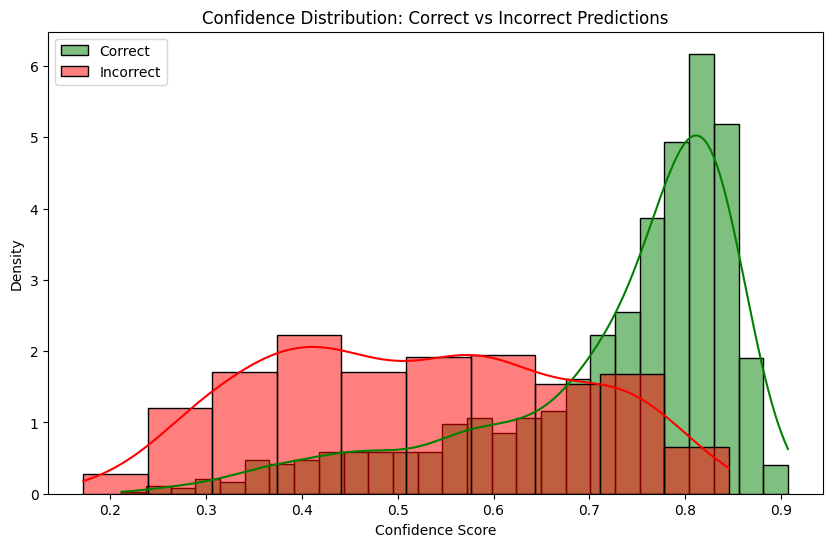

Average Confidence (Correct): 0.7238
Average Confidence (Incorrect): 0.5198


In [ ]:
# confidence for correct vs incorrect predictions
confidences = np.max(probs, axis=1)
correct_mask = preds == labels
incorrect_mask = ~correct_mask

plt.figure(figsize=(10, 6))
sns.histplot(confidences[correct_mask], color='green', label='Correct', kde=True, stat="density", alpha=0.5)
sns.histplot(confidences[incorrect_mask], color='red', label='Incorrect', kde=True, stat="density", alpha=0.5)
plt.title("Confidence Distribution: Correct vs Incorrect Predictions")
plt.xlabel("Confidence Score")
plt.legend()
plt.show()

print(f"Average Confidence (Correct): {np.mean(confidences[correct_mask]):.4f}")
print(f"Average Confidence (Incorrect): {np.mean(confidences[incorrect_mask]):.4f}")

## Specific Misclassified Examples

We identify specific songs that are misclassified.
Since we split songs into chunks, we aggregate predictions by song to see if the whole song is problematic or just parts of it.

In [ ]:
import pandas as pd

def analyze_misclassified_songs(model, loader, genre_names, device):
    model.eval()
    
    # loader.dataset is ChunkedDataset
    # loader.dataset.dataset is Subset
    # loader.dataset.dataset.dataset is GTZANDataset
    
    chunked_ds = loader.dataset
    if not hasattr(chunked_ds, 'dataset'):
        print("Error: Loader dataset is not a ChunkedDataset or wrapper as expected.")
        return
        
    subset = chunked_ds.dataset
    if not hasattr(subset, 'dataset'):
        original_ds = subset
        indices = range(len(original_ds))
    else:
        original_ds = subset.dataset
        indices = subset.indices
        
    num_chunks = chunked_ds.num_chunks
    
    results = []
    
    print(f"Analyzing {len(indices)} songs...")
    
    with torch.no_grad():
        for i, song_idx in enumerate(tqdm(indices)):
            filename = original_ds.files[song_idx]
            true_label_idx = original_ds.labels[song_idx]
            true_label = genre_names[true_label_idx]
            
            # chunk indices are i * num_chunks to (i+1) * num_chunks
            
            chunk_preds = []
            chunk_confs = []
            
            start_chunk_idx = i * num_chunks
            
            chunks = []
            for j in range(num_chunks):
                chunk, _ = chunked_ds[start_chunk_idx + j]
                chunks.append(chunk)
                
            batch = torch.stack(chunks).to(device)
            outputs = model(batch)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            # Aggregate predictions
            avg_probs = torch.mean(probs, dim=0)
            pred_label_idx = torch.argmax(avg_probs).item()
            pred_label = genre_names[pred_label_idx]
            confidence = avg_probs[pred_label_idx].item()
            
            if pred_label_idx != true_label_idx:
                results.append({
                    'Filename': Path(filename).name,
                    'True Genre': true_label,
                    'Predicted Genre': pred_label,
                    'Confidence': confidence,
                    'Full Path': filename
                })
                
    return pd.DataFrame(results)

df_misclassified = analyze_misclassified_songs(model, test_loader, GENRE_NAMES, device)

# high confidence errors are most interesting
df_misclassified = df_misclassified.sort_values('Confidence', ascending=False)

print(f"\nFound {len(df_misclassified)} misclassified songs out of {len(test_loader.dataset)//test_loader.dataset.num_chunks} total test songs.")

print("\nTop 20 High-Confidence Misclassifications:")
display(df_misclassified.head(20))

df_misclassified.to_csv(run_dir / "misclassified_songs.csv", index=False)
print(f"\nFull list saved to {run_dir / 'misclassified_songs.csv'}")

Analyzing 100 songs...


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


Found 18 misclassified songs out of 100 total test songs.

Top 20 High-Confidence Misclassifications:


,Filename,True Genre,Predicted Genre,Confidence,Full Path
11,reggae.00022.wav,reggae,hiphop,0.725262,c:\Users\mar20\Desktop\Natural Language Proces...
1,disco.00021.wav,disco,pop,0.662005,c:\Users\mar20\Desktop\Natural Language Proces...
8,pop.00062.wav,pop,hiphop,0.649065,c:\Users\mar20\Desktop\Natural Language Proces...
13,classical.00032.wav,classical,reggae,0.598295,c:\Users\mar20\Desktop\Natural Language Proces...
4,rock.00051.wav,rock,pop,0.584854,c:\Users\mar20\Desktop\Natural Language Proces...
16,disco.00020.wav,disco,country,0.526094,c:\Users\mar20\Desktop\Natural Language Proces...
17,disco.00085.wav,disco,hiphop,0.492773,c:\Users\mar20\Desktop\Natural Language Proces...
2,pop.00010.wav,pop,country,0.474370,c:\Users\mar20\Desktop\Natural Language Proces...
0,rock.00063.wav,rock,jazz,0.444473,c:\Users\mar20\Desktop\Natural Language Proces...
12,metal.00060.wav,metal,rock,0.429685,c:\Users\mar20\Desktop\Natural Language Proces...



Full list saved to ..\runs\20251202_114502\misclassified_songs.csv



## Pairwise Confusion Analysis

We look at specific pairs of genres that are confused.
For example, which country songs are confused with rock?

In [ ]:
confusion_pairs = df_misclassified.groupby(['True Genre', 'Predicted Genre']).size().reset_index(name='Count')
confusion_pairs = confusion_pairs.sort_values('Count', ascending=False)

print("Most Common Confusions (Song Level):")
display(confusion_pairs.head(10))

if not confusion_pairs.empty:
    top_confusion = confusion_pairs.iloc[0]
    true_g = top_confusion['True Genre']
    pred_g = top_confusion['Predicted Genre']
    
    print(f"\nFiles where True='{true_g}' but Predicted='{pred_g}':")
    subset = df_misclassified[(df_misclassified['True Genre'] == true_g) & (df_misclassified['Predicted Genre'] == pred_g)]
    display(subset[['Filename', 'Confidence']])

Most Common Confusions (Song Level):


,True Genre,Predicted Genre,Count
14,rock,pop,2
9,reggae,hiphop,2
0,blues,country,1
1,classical,reggae,1
4,disco,pop,1
5,metal,rock,1
2,disco,country,1
3,disco,hiphop,1
7,pop,disco,1
6,pop,country,1



Files where True='rock' but Predicted='pop':


,Filename,Confidence
4,rock.00051.wav,0.584854
7,rock.00052.wav,0.235093
